In [1]:
import xgboost as xgb
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import yaml
import datetime
import sys
from tqdm import tqdm
import os
import random
import pickle
from glob import glob
import gc
from multiprocessing import Pool, cpu_count

import warnings
warnings.filterwarnings('ignore')

sys.path.append('/kaggle')
from utils.xgb import fit_xgb, inference_xgb
from utils.metric import compute_comptetition_metric
from utils.feature_contena import Features
from utils.pandas_utils import reduce_mem_usage

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [2]:
config = f"""
execution:
    exp_id: exp_036
    debug: False
    submit: False
    multiprocessing: True

dataset: 
    competition_dir: /kaggle/input/child-mind-institute-detect-sleep-states
    cv_split_path: /kaggle/input/cv_split/train_folds.csv
    train_base_path: /kaggle/input/train_base/train_base.csv
    step_csv_dir: /kaggle/input/save_series_csv/csvs

feature:
    agg_freq: 24 # [step]

xgboost:    
    objective: "binary:logistic"
    learning_rate: 0.1  # 0.01で固定。学習時間とのトレードオフ
    reg_alpha: 0.02  # L1正則化。0.1が推奨。
    reg_lambda: 0.2  # L2正則化。0.1が推奨
    random_state: 42
    max_depth: 5  # 3-8。7くらいでいい。
    colsample_bytree: 0.7  # カラムが多い時は少なめ(0.4とか)にする。
    
seed: 46
"""

CFG = yaml.load(config, Loader=yaml.SafeLoader)

CFG["output_dir"] = f"/kaggle/output/{CFG['execution']['exp_id']}"
os.makedirs(CFG["output_dir"], exist_ok=True)

In [3]:
train = pd.read_csv(os.path.join("/kaggle/output", os.path.join(CFG["execution"]["exp_id"], "oof.csv")))
train["oof"] = train["oof"].fillna(1)
train.head()

,target,step,series_id,fold,oof_stage1,STAGE_stage1,raw_oof,oof_stage2,STAGE_stage2,minutes,oof
0,1,11.5,038441c925bb,2,NaN,2,0.999819,NaN,NaN,NaN,1.0
1,1,35.5,038441c925bb,2,NaN,2,0.999644,NaN,NaN,NaN,1.0
2,1,59.5,038441c925bb,2,NaN,2,0.993865,NaN,NaN,NaN,1.0
3,1,83.5,038441c925bb,2,NaN,2,0.995005,NaN,NaN,NaN,1.0
4,1,107.5,038441c925bb,2,NaN,2,0.994551,NaN,NaN,NaN,1.0


In [4]:
dfs = []
for series_id, df in tqdm(train.groupby("series_id")):
    df = df.reset_index(drop=True)
    wakeup_index = np.array([i for i in range(1, len(df["oof"])) if df["oof"][i-1] < 0.5 and df["oof"][i] >= 0.5])
    onset_index = np.array([i for i in range(1, len(df["oof"])) if df["oof"][i-1] > 0.5 and df["oof"][i] <= 0.5])

    sub_idxs = []
    for i in range(len(wakeup_index)):
        idx_diff = wakeup_index[i] - (onset_index[i] if i < len(onset_index) else 0)
        if idx_diff >= 15 or idx_diff < 0:
            sub_idxs.append(i)
    wakeup_index = wakeup_index[sub_idxs]
    onset_index = onset_index[[idx for idx in sub_idxs if idx < len(onset_index)]]

    SCORE_DURATION = 12
    wakeup_scores = []
    for idx in wakeup_index:
        wakeup_scores.append(df["oof"].values[min(idx + SCORE_DURATION, len(df) - 1)] - df["oof"].values[max(0, idx - SCORE_DURATION)])
    onset_scores = []
    for idx in onset_index:
        onset_scores.append(-df["oof"].values[min(idx + SCORE_DURATION, len(df) - 1)] + df["oof"].values[max(0, idx - SCORE_DURATION)])

    sub = pd.concat([
        pd.DataFrame({
            "series_id": series_id,
            "raw_step": df["step"].values[wakeup_index],
            "event": "wakeup",
            "score": wakeup_scores,
        }) if len(wakeup_index) > 0 else pd.DataFrame(),
        pd.DataFrame({
            "series_id": series_id,
            "raw_step": df["step"].values[onset_index],
            "event": "onset",
            "score": onset_scores,
        }) if len(onset_index) > 0 else pd.DataFrame(),
    ])
    if len(sub) > 0:
        sub["step"] = (sub["raw_step"] - CFG["feature"]["agg_freq"] // 2).astype(int)
        dfs.append(sub)

    if False:
        fig, axs = plt.subplots(3, 1, figsize=(20, 7))
        axs[0].plot(df["oof"])
        axs[0].plot(df["target"])
        axs[0].scatter(wakeup_index, [0.5 for _ in wakeup_index], c="red")
        axs[0].scatter(onset_index, [0.5 for _ in onset_index], c="green")
        df = pd.read_csv(f"{CFG['dataset']['step_csv_dir']}/{df['series_id'].values[0]}.csv")
        axs[1].plot(df["enmo"])
        axs[2].plot(df["anglez"])
        plt.suptitle(f"series_id: {series_id}")
        plt.tight_layout()
        path = os.path.join(CFG["output_dir"], f"series_graph/{series_id}.png")
        os.makedirs(os.path.dirname(path), exist_ok=True)
        plt.savefig(path)
        plt.close()
sub = pd.concat(dfs).reset_index(drop=True)
sub.to_csv(os.path.join(CFG["output_dir"], "submission.csv"), index=False)
sub.head()

100%|██████████| 277/277 [00:46<00:00,  6.01it/s]


,series_id,raw_step,event,score,step
0,038441c925bb,10931.5,wakeup,0.812971,10919
1,038441c925bb,23987.5,wakeup,-0.095061,23975
2,038441c925bb,27467.5,wakeup,0.883293,27455
3,038441c925bb,43979.5,wakeup,0.422262,43967
4,038441c925bb,61091.5,wakeup,0.647474,61079


score: 0.6422


event   tolerance
onset   12           0.055581
        36           0.321672
        60           0.504637
        90           0.623880
        120          0.711564
        150          0.755652
        180          0.783137
        240          0.815259
        300          0.836540
        360          0.848971
wakeup  12           0.094732
        36           0.380331
        60           0.543274
        90           0.666327
        120          0.726407
        150          0.771679
        180          0.803737
        240          0.841947
        300          0.871667
        360          0.886395
dtype: float64

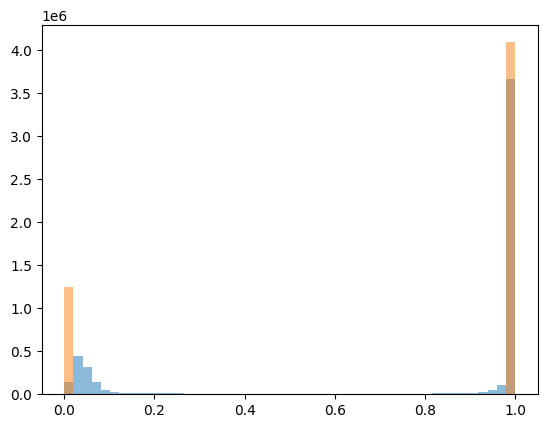

In [5]:
labels = pd.read_csv(f"{CFG['dataset']['competition_dir']}/train_events.csv").dropna()
score, ap_table = compute_comptetition_metric(labels, sub)
print(f"score: {score:.4f}")
display(ap_table)
plt.hist(train["oof"], bins=np.linspace(0, 1, 50), alpha=0.5)
plt.hist(train["target"], bins=np.linspace(0, 1, 50), alpha=0.5)
plt.show()

In [6]:
len(sub), len(labels)

(10700, 9585)

In [7]:
sub.duplicated().sum()

0